# **Part 1: Exploratory Data Analysis (EDA)**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from scipy import stats
from scipy.stats import chi2_contingency

## **Load and inspect dataset structure**

In [2]:
df = pd.read_csv("../data/raw/coronary_disease.csv")

In [3]:
df.head(10)

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,M,39,4.0,No,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,F,46,2.0,No,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,M,48,1.0,Yes,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,F,61,3.0,Yes,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,F,46,3.0,Yes,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,F,43,2.0,No,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,F,63,1.0,No,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,F,45,2.0,Yes,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,M,52,1.0,No,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,M,43,1.0,Yes,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


In [4]:
print("Dataset shape:", df.shape)
print("Number of observations:", df.shape[0])

Dataset shape: (4238, 16)
Number of observations: 4238


In [5]:
# Column names
df.columns.tolist()

['sex',
 'age',
 'education',
 'currentSmoker',
 'cigsPerDay',
 'BPMeds',
 'prevalentStroke',
 'prevalentHyp',
 'diabetes',
 'totChol',
 'sysBP',
 'diaBP',
 'BMI',
 'heartRate',
 'glucose',
 'TenYearCHD']

In [6]:
# Rename columns to make them more uniform
df = df.rename(
    columns={
        "education": "education_level",
        "currentSmoker": "current_smoker",
        "cigsPerDay": "cigarettes_per_day",
        "BPMeds": "bp_medication",
        "prevalentStroke": "previous_stroke",
        "prevalentHyp": "hypertension",
        "totChol": "total_cholesterol",
        "sysBP": "systolic_bp",
        "diaBP": "diastolic_bp",
        "BMI": "bmi",
        "heartRate": "heart_rate",
        "TenYearCHD": "ten_year_chd",
    }
)

In [7]:
# Check variable types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 4238 non-null   object 
 1   age                 4238 non-null   int64  
 2   education_level     4133 non-null   float64
 3   current_smoker      4238 non-null   object 
 4   cigarettes_per_day  4209 non-null   float64
 5   bp_medication       4185 non-null   float64
 6   previous_stroke     4238 non-null   int64  
 7   hypertension        4238 non-null   int64  
 8   diabetes            4238 non-null   int64  
 9   total_cholesterol   4188 non-null   float64
 10  systolic_bp         4238 non-null   float64
 11  diastolic_bp        4238 non-null   float64
 12  bmi                 4219 non-null   float64
 13  heart_rate          4237 non-null   float64
 14  glucose             3850 non-null   float64
 15  ten_year_chd        4238 non-null   int64  
dtypes: flo

In [8]:
# Change variable types
df["education_level"] = df["education_level"].astype("Int64")

# Binary categorical variables
df["sex"] = df["sex"].map({"M": 1, "F": 0}).astype("int")
df["current_smoker"] = df["current_smoker"].map({"Yes": 1, "No": 0}).astype("int")
df["bp_medication"] = df["bp_medication"].astype("Int64")
df["previous_stroke"] = df["previous_stroke"].astype("int")
df["hypertension"] = df["hypertension"].astype("int")
df["diabetes"] = df["diabetes"].astype("int")

## **Analyze missing values**

In [9]:
# Calculate missing values
missing_count = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame(
    {"Missing Values": missing_count, "Percentage": missing_percent}
)

missing_df = missing_df.sort_values(by="Missing Values", ascending=False)

missing_df

,Missing Values,Percentage
glucose,388,9.155262
education_level,105,2.477584
bp_medication,53,1.250590
total_cholesterol,50,1.179802
cigarettes_per_day,29,0.684285
bmi,19,0.448325
heart_rate,1,0.023596
sex,0,0.000000
age,0,0.000000
current_smoker,0,0.000000


To address missing values, we will apply simple imputation for variables with less than 5% missing data. For numerical variables, missing values will be replaced with the median, while for categorical variables, the mode will be used.

In [10]:
# Separate numeric and binary categorical columns
numerical_cols = [
    col for col in df.select_dtypes(include="number").columns if df[col].nunique() > 4
]

categorical_cols = [
    col for col in df.select_dtypes(include="number").columns if df[col].nunique() <= 4
]

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['age', 'cigarettes_per_day', 'total_cholesterol', 'systolic_bp', 'diastolic_bp', 'bmi', 'heart_rate', 'glucose']
Categorical columns: ['sex', 'education_level', 'current_smoker', 'bp_medication', 'previous_stroke', 'hypertension', 'diabetes', 'ten_year_chd']


In [11]:
# Filter columns with <5% missing
numerical_cols_to_impute = [
    col for col in numerical_cols if df[col].isnull().mean() < 0.05
]
categorical_cols_to_impute = [
    col for col in categorical_cols if df[col].isnull().mean() < 0.05
]

# Impute numerical columns with median
for col in numerical_cols_to_impute:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

# Impute categorical columns with mode
for col in categorical_cols_to_impute:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

For glucose, which has over 5% missing values (9.16%), we will use KNN imputation because glucose is clinically important and is correlated with BMI, blood pressure, and cholesterol, making this method suitable for estimating the missing values.

In [12]:
# Columns to use as predictors
predictors = [
    "glucose",
    "age",
    "bmi",
    "systolic_bp",
    "diastolic_bp",
    "total_cholesterol",
    "heart_rate",
    "cigarettes_per_day",
]

knn_imputer = KNNImputer(n_neighbors=5)

imputed_values = knn_imputer.fit_transform(df[predictors])

df["glucose"] = imputed_values[:, 0]

## **Analyze Outliers**

In [13]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
sex,4238.0,0.429212,0.495022,0.0,0.0,0.0,1.0,1.0
age,4238.0,49.584946,8.57216,32.0,42.0,49.0,56.0,70.0
education_level,4238.0,1.954696,1.01851,1.0,1.0,2.0,3.0,4.0
current_smoker,4238.0,0.494101,0.500024,0.0,0.0,0.0,1.0,1.0
cigarettes_per_day,4238.0,8.941482,11.902399,0.0,0.0,0.0,20.0,70.0
bp_medication,4238.0,0.029259,0.168552,0.0,0.0,0.0,0.0,1.0
previous_stroke,4238.0,0.005899,0.076587,0.0,0.0,0.0,0.0,1.0
hypertension,4238.0,0.310524,0.462763,0.0,0.0,0.0,1.0,1.0
diabetes,4238.0,0.02572,0.158316,0.0,0.0,0.0,0.0,1.0
total_cholesterol,4238.0,236.689476,44.327427,107.0,206.0,234.0,262.0,696.0


In [14]:
# Detect outliers using IQR method
def outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers


outlier_iqr_summary = {}

for col in numerical_cols:
    outliers = outliers_iqr(df[col])
    outlier_iqr_summary[col] = {
        "Count": len(outliers),
        "Percentage": len(outliers) / len(df) * 100,
    }

outlier_iqr_summary_df = pd.DataFrame(outlier_iqr_summary).T.sort_values(
    by="Count", ascending=False
)
outlier_iqr_summary_df

,Count,Percentage
glucose,232.0,5.474280
systolic_bp,126.0,2.973101
bmi,97.0,2.288815
diastolic_bp,81.0,1.911279
heart_rate,76.0,1.793299
total_cholesterol,57.0,1.344974
cigarettes_per_day,12.0,0.283152
age,0.0,0.000000


In [15]:
# Detect outliers using Z-score (>3)
outlier_zscore_summary = {}

for col in numerical_cols:
    z_score = np.abs(stats.zscore(df[col]))
    num_outliers_zscore = np.sum(z_score > 3)
    percent_outliers_zscore = num_outliers_zscore / len(df) * 100
    outlier_zscore_summary[col] = {
        "Count": num_outliers_zscore,
        "Percentage": percent_outliers_zscore,
    }

outlier_zscore_summary_df = pd.DataFrame(outlier_zscore_summary).T.sort_values(
    by="Count", ascending=False
)
outlier_zscore_summary_df

,Count,Percentage
bmi,60.0,1.415762
glucose,50.0,1.179802
systolic_bp,48.0,1.132610
diastolic_bp,41.0,0.967437
total_cholesterol,25.0,0.589901
heart_rate,23.0,0.542709
cigarettes_per_day,21.0,0.495517
age,0.0,0.000000


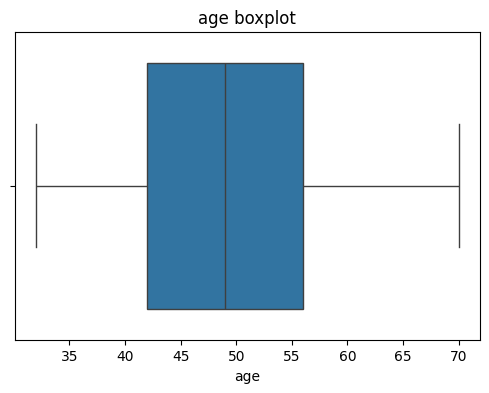

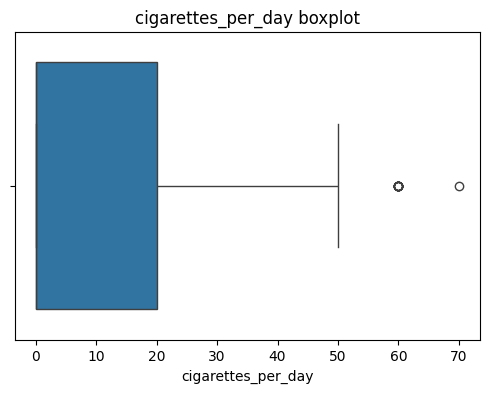

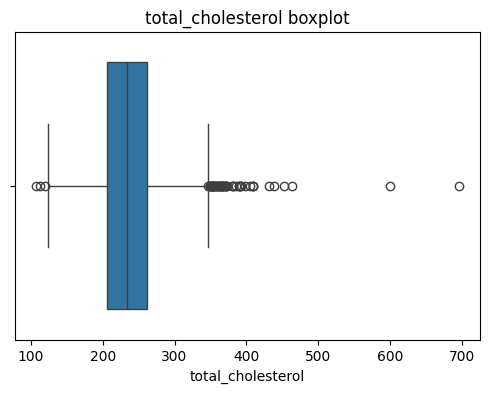

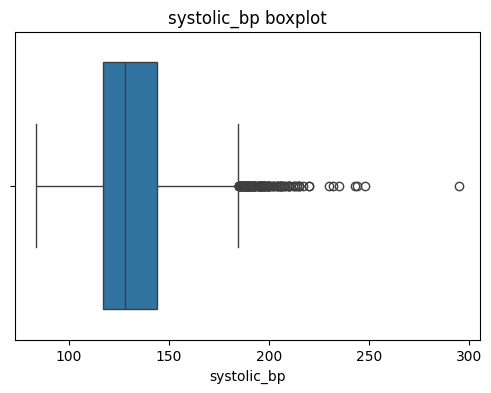

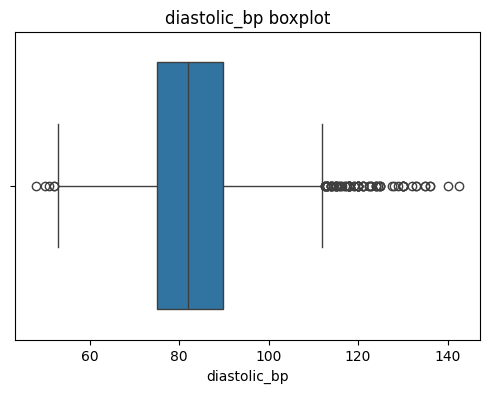

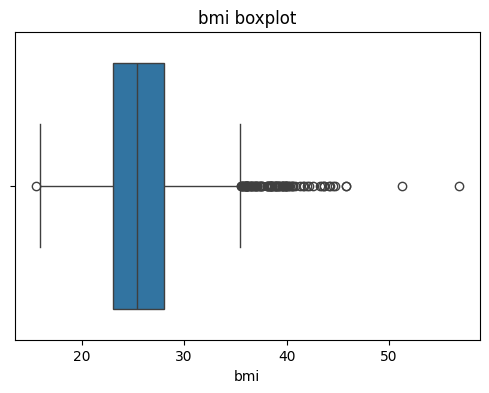

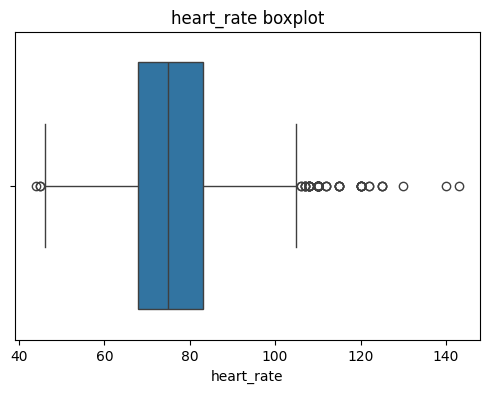

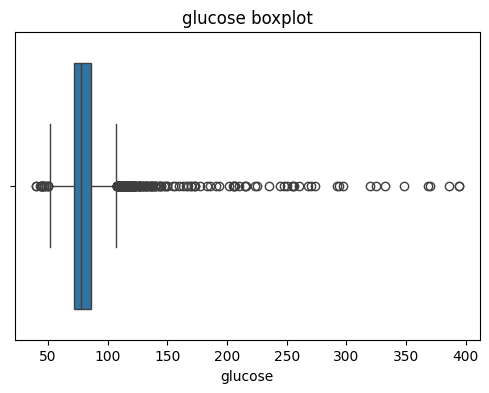

In [16]:
# Outliers visualization
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(col + " boxplot")
    plt.show()

Outliers were identified using both IQR and Z-score methods. We can see that the IQR method finds more outliers than Z-score this is because Z-score (>3) only flags extreme values.

Since these extreme values may correspond to clinically relevant cases, outliers were retained.

In [17]:
# Save cleaned df
df.to_csv("../data/processed/cleaned_coronary_data.csv", index=False)